In [1]:
import os
import math
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import neuromancer as nm
from neuromancer.problem import Problem
from neuromancer.loss import PenaltyLoss
from neuromancer.trainer import Trainer
from neuromancer.system import Node, System
from neuromancer.dynamics import integrators, ode
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import Dataset, DataLoader

In [2]:
filepath = "/Users/sdutta/OneDrive - Johns Hopkins/Documents/SciML/project/"
chartpath = "/Users/sdutta/OneDrive - Johns Hopkins/Documents/SciML/project/charts/"

In [3]:
ds = xr.open_dataset("regridded_data/2015-2021_combined.nc")

In [4]:
mu_ref = 5.0
k_dfe = 3 ** (-0.5)
k_no3 = 0.5
k_po4 = 0.01
ds['V_dfe'] = ds['dfe'] / (k_dfe + ds['dfe'])
ds['V_no3'] = ds['no3'] / (k_no3 + ds['no3'])
ds['V_po4'] = ds['po4'] / (k_po4 + ds['po4'])
ds['Tf'] = 1.7 ** np.exp((ds['sst'] - 30) / 10)

# Convert to NumPy arrays, compute the minimum, and then convert back to xarray
V_no3_array = ds['V_no3'].values  # Convert to NumPy array
V_po4_array = ds['V_po4'].values  # Convert to NumPy array
V_dfe_array = ds['V_dfe'].values   # Assuming V_dfe is already defined

# Calculate the minimum using NumPy
V_min = np.minimum(np.minimum(V_dfe_array, V_po4_array), V_no3_array)

# Assign the result back to the DataArray in the xarray Dataset
ds['V'] = xr.DataArray(V_min, dims=ds['V_dfe'].dims, coords=ds['V_dfe'].coords)

df = ds.to_dataframe()
df = df.dropna(how='any')
scaler = MinMaxScaler(feature_range=(0,10))
scaled_array = scaler.fit_transform(df)
norm_df = pd.DataFrame(scaled_array, index=df.index, columns=df.columns)
print(norm_df.head())
print(norm_df.info())

                              dfe       no3       po4       sil       rsn  \
lon    lat   month_year                                                     
-179.5 -76.5 2015-01-01  0.042463  2.457866  5.414602  2.663714  6.223525   
             2015-02-01  0.056386  2.517316  5.486631  2.416398  3.783490   
             2015-12-01  0.048093  2.668628  5.709538  3.263838  8.403666   
             2016-01-01  0.033411  2.665089  5.803986  3.021275  5.299753   
             2016-02-01  0.066006  2.360248  5.209874  2.289098  3.853204   

                              mld       ssh       sal       sst      chla  \
lon    lat   month_year                                                     
-179.5 -76.5 2015-01-01  0.031551  1.773168  7.995484  0.429358  0.053512   
             2015-02-01  0.096969  1.718363  8.200290  0.225703  0.076863   
             2015-12-01  0.076738  1.647681  8.305805  0.355078  0.401371   
             2016-01-01  0.089604  1.587883  8.291054  0.466634  0.112831  

In [5]:
class PlanktonTrajectoryDataset(Dataset):
    def __init__(self, norm_df):
        df = norm_df.copy()
        # Assume df is your full dataset
        df = df.reset_index()  # moves month_year, lat, lon from index to columns

        # Convert month_year to a numeric index (e.g., months since start)
        df['time'] = (pd.to_datetime(df['month_year']) - pd.to_datetime(df['month_year'].min())).dt.days / 30.0

        # Optional: sort by time to ensure trajectories are ordered
        df = df.sort_values(['lat', 'lon', 'time']).reset_index(drop=True)

        assert not df[['Tf','rsn','V','logmcro']].isnull().any().any()
        assert (df[['Tf','rsn','V','logmcro']].dtypes != object).all()

        self.trajs = []
        for (lat, lon), grp in df.groupby(['lat', 'lon']):
            grp = grp.reset_index()
            t = torch.arange(len(grp), dtype=torch.float32)
            Tf = torch.tensor(grp['Tf'].values, dtype=torch.float32)
            I = torch.tensor(grp['rsn'].values, dtype=torch.float32)
            V = torch.tensor(grp['V'].values, dtype=torch.float32)
            P = torch.tensor(grp['logmcro'].values, dtype=torch.float32)
            # P = torch.tensor(grp['chla'].values, dtype=torch.float32).unsqueeze(-1)  # <-- fix here
            X = torch.stack([Tf, I, V], dim=-1)
            self.trajs.append({'t': t, 'X': X, 'P': P})

    def __len__(self):
        return len(self.trajs)

    def __getitem__(self, idx):
        return self.trajs[idx]

# --------------------------------------------------------------------
# 2. Collate function with padding + mask
# --------------------------------------------------------------------
def collate_dicts(batch, max_len=72):
    """Pads all trajectories in batch to global max_len and returns dict."""
    Xs, Ps, masks = [], [], []

    for b in batch:
        T = b['P'].shape[0]
        pad = max_len - T
        X_pad = torch.cat([b['X'], torch.zeros(pad, b['X'].shape[1])], dim=0)
        P_pad = torch.cat([b['P'].unsqueeze(-1), torch.zeros(pad, 1)], dim=0)
        mask = torch.cat([torch.ones(T), torch.zeros(pad)], dim=0)

        Xs.append(X_pad)
        Ps.append(P_pad)
        masks.append(mask)

    return {
        'X': torch.stack(Xs),       # (B, max_len, 3)
        'P': torch.stack(Ps),       # (B, max_len, 1)
        'mask': torch.stack(masks)  # (B, max_len)
    }

# -------------------------
# HybridRHS
# -------------------------
class HybridRHS(nn.Module):
    def __init__(self, n_inputs=3, n_hidden=32, n_outputs=1):
        super().__init__()
        self.n_inputs = n_inputs
        self.in_features = 1 + n_inputs  # P + forcings
        self.out_features = n_outputs

        # Mechanistic parameters
        # self.mu_ref = nn.Parameter(torch.tensor(1.0))
        self.mu_ref = torch.tensor(5.0)
        # self.alpha_Chl = nn.Parameter(torch.tensor(0.1))
        self.alpha_Chl =torch.tensor(0.28)
        self.m = nn.Parameter(torch.tensor(0.05))
        self.alpha = nn.Parameter(torch.tensor(0.01))

        # Neural network correction
        self.nn = nn.Sequential(
            nn.Linear(self.in_features, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, n_outputs)
        )

        # Neural network for theta
        self.theta_net = nn.Sequential(
            nn.Linear(n_inputs, 8),
            nn.Tanh(),
            nn.Linear(8, 1),
            nn.Softplus()  # ensures theta > 0
        )

        with torch.no_grad():
            self.nn[0].weight.mul_(0.1)
            self.nn[0].bias.mul_(0.0)
            self.nn[-1].weight.mul_(0.01)
            self.nn[-1].bias.mul_(0.0)

            self.theta_net[0].weight.mul_(0.1)
            self.theta_net[0].bias.mul_(0.0)
            self.theta_net[-2].weight.mul_(0.01)
            self.theta_net[-2].bias.mul_(0.0)

    def forward(self, P, u):
        # Ensure shapes
        if P.dim() == 1:
            P = P.unsqueeze(-1)
        if u.dim() == 1:
            u = u.unsqueeze(0)
        if P.dim() == 3 and P.shape[1] == 1 and P.shape[2] == 1:
            P = P.squeeze(1).squeeze(-1).unsqueeze(-1)
        if u.dim() == 3:
            u = u.view(u.shape[0], -1)

        B = P.shape[0]
        P = P.reshape(B, -1)
        u = u.reshape(B, -1)

        # Clamp inputs
        P_safe = torch.clamp(P, 1e-6, 1e3)
        Tf = torch.clamp(u[:, 0:1], 1e-3, 10.0)
        I  = torch.clamp(u[:, 1:2], 0.0, 1e3)
        V  = torch.clamp(u[:, 2:3], 1e-3, 1e3)

        # Clamp neural network correction output
        inp = torch.cat([P_safe, u[:, :self.n_inputs]], dim=-1)
        correction = 0.01 * torch.tanh(self.nn(inp))  # bounded [-0.01,0.01]

        # Learnable theta from forcing inputs
        theta = self.theta_net(u[:, :self.n_inputs])  # shape: (B, 1)

        # Mechanistic dynamics
        denom = torch.clamp(self.mu_ref * Tf * V, min=1e-3)
        exponent = torch.clamp(-self.alpha_Chl * theta * I / denom, min=-50.0, max=50.0)
        growth = self.mu_ref * Tf * (1 - torch.exp(exponent)) * V * P_safe
        mortality = self.m * Tf * P_safe
        aggregation = self.alpha * P_safe ** 1.75

        dPdt = growth + correction - mortality - aggregation

        # final safety clamp
        dPdt = torch.nan_to_num(dPdt, nan=0.0, posinf=1e6, neginf=-1e6)
        return dPdt

# --------------------------------------------------------------------
# 4. Data preparation
# --------------------------------------------------------------------
# df is your full DataFrame
from functools import partial

dataset = PlanktonTrajectoryDataset(norm_df)
max_len = max(len(traj['t']) for traj in dataset)
n = len(dataset)
n_train = int(0.8*n)
n_val = int(0.1*n)
n_test = n - n_train - n_val

train_ds, val_ds, test_ds = torch.utils.data.random_split(dataset, [n_train, n_val, n_test],
                                                         generator=torch.Generator().manual_seed(42))

collate_fixed = partial(collate_dicts, max_len=max_len)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=collate_dicts)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, collate_fn=collate_dicts)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, collate_fn=collate_dicts)

In [6]:
import csv, os

if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

# device = 'cuda' if torch.cuda.is_available() elif device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(device)

# --------------------------------------------------------------------
# Model setup
# --------------------------------------------------------------------
fx = HybridRHS(n_inputs=3, n_hidden=64, n_outputs=1).to(device)
fxRK4 = integrators.RK4(fx, h=0.1)
ude = Node(fxRK4, ['xn', 'un'], ['xn'], name='UDE')
dynamics_model = System([ude], nsteps=max_len - 1).to(device)

optimizer = torch.optim.Adam(fx.parameters(), lr=1e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-7
)

# --------------------------------------------------------------------
# Paths
# --------------------------------------------------------------------
log_dir = "checkpoints"
os.makedirs(log_dir, exist_ok=True)
log_path = os.path.join(log_dir, "training_log.csv")
best_model_path = os.path.join(log_dir, "best_model.pt")

mps


In [7]:
for f in os.listdir(log_dir):
    print(f)

parameter_evolution.png
loss_curve.png
best_model.pt
training_log.csv


In [8]:
# Load the checkpoint
checkpoint = torch.load("checkpoints/best_model.pt", map_location=device, weights_only=True)

# Extract the best parameters
best_params = checkpoint.get('params', {})
m_best = best_params.get('m', None)
alpha_best = best_params.get('alpha', None)

print("📌 Best Parameters:")
print(f"  m:     {m_best}")
print(f"  alpha: {alpha_best}")

📌 Best Parameters:
  m:     0.08969714492559433
  alpha: 0.03203783184289932


In [9]:
# --- Load trained model from checkpoint ---
fx = HybridRHS(n_inputs=3, n_hidden=64, n_outputs=1).to(device)

checkpoint = torch.load("checkpoints/best_model.pt", map_location=device, weights_only=True)
fx.load_state_dict(checkpoint['model_state_dict'])
fx.eval() 

# Neural network correction
nn_correction = fx.nn

# Theta network
theta_net = fx.theta_net

# Mechanistic parameters
m_value = fx.m.item()
alpha_value = fx.alpha.item()

print(nn_correction)
print(theta_net)
print(f"m = {m_value}, alpha = {alpha_value}")

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): Tanh()
  (2): Linear(in_features=64, out_features=1, bias=True)
)
Sequential(
  (0): Linear(in_features=3, out_features=8, bias=True)
  (1): Tanh()
  (2): Linear(in_features=8, out_features=1, bias=True)
  (3): Softplus(beta=1.0, threshold=20.0)
)
m = 0.08969714492559433, alpha = 0.03203783184289932


In [10]:
# Sort by time
df = norm_df.reorder_levels(['lon', 'lat', 'month_year']).sort_index()
print(df.index.names)

['lon', 'lat', 'month_year']


In [11]:
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy.interpolate import interp1d
from dateutil.relativedelta import relativedelta

# ----------------------------
# Helper functions
# ----------------------------
def months_since_start(dates):
    """Convert datetime-like array to months since first date."""
    dates = pd.to_datetime(dates)
    return np.array([(d.year - dates[0].year) * 12 + (d.month - dates[0].month) for d in dates], dtype=np.float32)

def make_forcing_function(df_cell_agg, forcing_cols=['Tf','rsn','V']):
    """Create interpolating forcing function for a single cell."""
    df_cell_agg = df_cell_agg.dropna(subset=forcing_cols)

    # Convert time to numeric
    t_raw = months_since_start(df_cell_agg.index.get_level_values('month_year'))
    u_data = df_cell_agg[forcing_cols].values.astype(np.float32)

    # Round time to avoid float artifacts
    t_rounded = np.round(t_raw, decimals=4)
    t_unique, unique_idx = np.unique(t_rounded, return_index=True)
    u_data = u_data[unique_idx, :]

    if len(t_unique) < 2:
        raise ValueError("Too few unique time points for interpolation")

    # Interpolators
    u_interp = [interp1d(t_unique, u_data[:, i], kind='linear', fill_value='extrapolate') 
                for i in range(u_data.shape[1])]

    def forcing_func(t_query):
        return np.stack([f(t_query) for f in u_interp], axis=-1)

    return forcing_func, t_unique

def integrate_cell(df_cell_agg, fx, P0_col='logmcro'):
    """
    Integrate one cell given UDE model fx and aggregated cell dataframe.
    Returns (time_vector, P_pred_vector)
    """
    forcing_func, t_vals = make_forcing_function(df_cell_agg)
    fx.eval()
    # initial condition
    P0 = df_cell_agg[P0_col].iloc[0]
    un = torch.tensor(forcing_func(t_vals), dtype=torch.float32).unsqueeze(0).cpu()  # (1, T, 3)
    xn = torch.tensor([[[P0]]], dtype=torch.float32).cpu()  # (1, 1, 1)

    # Create System with correct nsteps
    fxRK4 = integrators.RK4(fx, h=0.1)
    ude = Node(fxRK4, ['xn', 'un'], ['xn'], name='UDE')
    local_model = System([ude], nsteps=un.shape[1] - 1).to('cpu')

    outputs = local_model({'xn': xn, 'un': un})
    P_pred = outputs['xn'].squeeze().detach().cpu().numpy()

    return t_vals, P_pred

def process_cell(lon, lat, fx, df):
    """Process one (lon, lat) cell: aggregate, integrate, return trajectory."""
    try:
        lon = float(lon)
        lat = float(lat)
        df_cell = df.loc[(lon, lat)]
        if df_cell.empty:
           raise ValueError("Empty cell")
        # Aggregate duplicates by month_year
        df_cell_agg = df_cell.groupby(level='month_year').mean()
        df_cell_agg = df_cell_agg.dropna(subset=['logmcro'])  # Drop months with missing logmcro

        if df_cell_agg.empty or 'logmcro' not in df_cell_agg.columns:
            raise ValueError("Missing logmcro")
            
        t, P_pred = integrate_cell(df_cell_agg, fx)
        obs = df_cell_agg['logmcro'].values
        return (lon, lat), pd.DataFrame({'time': t, 'P_pred': P_pred, 'obs': obs})
    except Exception as e:
        print(f"⚠️ Error at ({lon},{lat}): {e}")
        return (lon, lat), None

In [12]:
def is_valid_cell(df_cell, min_unique_months=2):
    """Check if a cell has enough unique time points for interpolation."""
    try:
        df_cell_agg = df_cell.groupby(level='month_year').mean()
        t_vals = months_since_start(df_cell_agg.index.get_level_values('month_year'))
        t_unique = np.unique(np.round(t_vals, decimals=4))
        return len(t_unique) >= min_unique_months
    except Exception:
        return False

# Get unique grid locations
all_locations = df.index.droplevel('month_year').unique()

# Filter to valid cells only
valid_locations = [loc for loc in all_locations if is_valid_cell(df.loc[loc])]
print(f"✅ Valid locations: {len(valid_locations)} / {len(all_locations)}")

✅ Valid locations: 37426 / 37821


In [13]:
# ----------------------------
# Parallel integration
# ----------------------------
import random
# test_locations = random.sample(list(locations), 10)

# Get unique grid locations
locations = df.index.droplevel('month_year').unique()

fx.to('cpu')  # move model to CPU for parallelization
dynamics_model.to('cpu')
print("fx device:", next(fx.parameters()).device)

# Run in parallel
results = Parallel(n_jobs=-1)(
    delayed(process_cell)(lon, lat, fx, df) for lon, lat in tqdm(valid_locations, ncols=100)
)

# Filter out failed cells
results_dict = {loc: traj for loc, traj in results if traj is not None}

fx device: cpu


100%|████████████████████████████████████████████████████████| 37426/37426 [02:50<00:00, 219.33it/s]


In [ ]:
# from joblib import Parallel, delayed
# from tqdm import tqdm

# # Get unique grid locations
# locations = df.index.droplevel('month_year').unique()

# fx.to('cpu')
# print("fx device:", next(fx.parameters()).device)

# # Wrap process_cell without passing tqdm
# def safe_process(lon, lat):
#     return process_cell(lon, lat, fx, df)

# # Use tqdm over the iterator
# results = []
# for result in tqdm(Parallel(n_jobs=-1)(delayed(safe_process)(lon, lat) for lon, lat in locations),
#                    total=len(locations), desc="Integrating cells", ncols=100):
#     results.append(result)

# # Filter out failed cells
# results_dict = {loc: traj for loc, traj in results if traj is not None}

In [25]:
# for lon, lat in test_locations:
#     loc, traj = process_cell(lon, lat, fx, df)
#     print(f"{loc}: {'✅' if traj is not None else '❌'}")

In [53]:
def plot_trajectory(loc, df_traj, name, path):
    t = df_traj['time']
    obs = df_traj['obs']
    pred = df_traj['P_pred']
    rmse = np.sqrt(mean_squared_error(obs, pred))
    r2 = r2_score(obs, pred)
    plt.figure(figsize=(12, 4))
    plt.plot(t, obs, label='Observed', lw=2)
    plt.plot(t, pred, label='Predicted', lw=2)
    plt.title(f'Trajectory at lon={loc[0]:.2f}, lat={loc[1]:.2f}\nRMSE={rmse:.2f}, R²={r2:.2f}', fontsize=12, fontweight='bold')
    plt.xlabel('Time (months since start)', fontsize=10)
    plt.ylabel('logmcro', fontsize=10)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(path + name, bbox_inches='tight', dpi=300)
    plt.show()

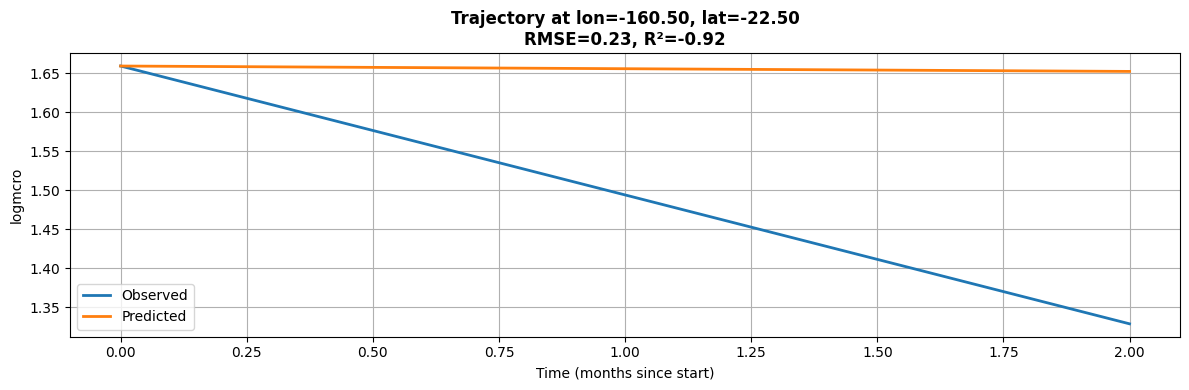

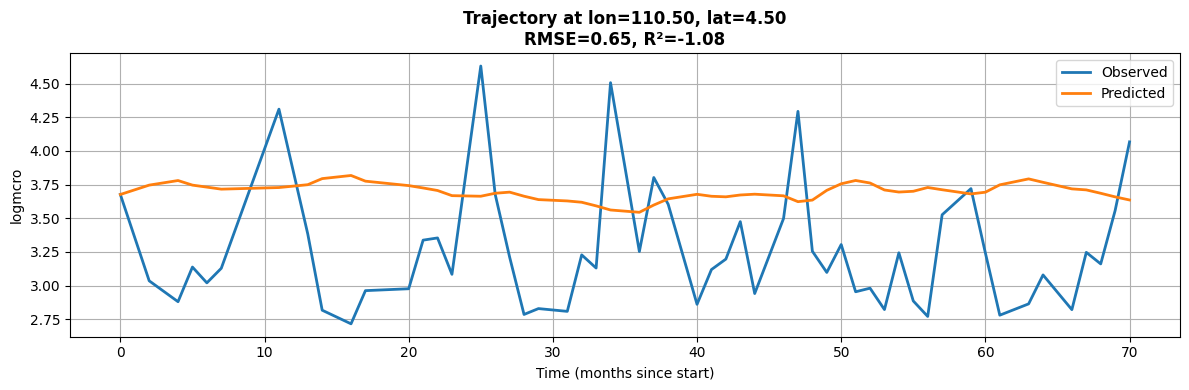

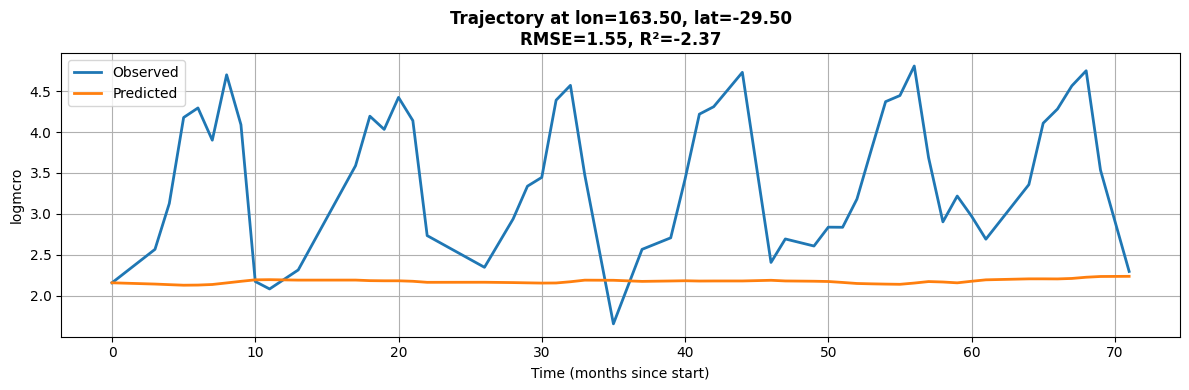

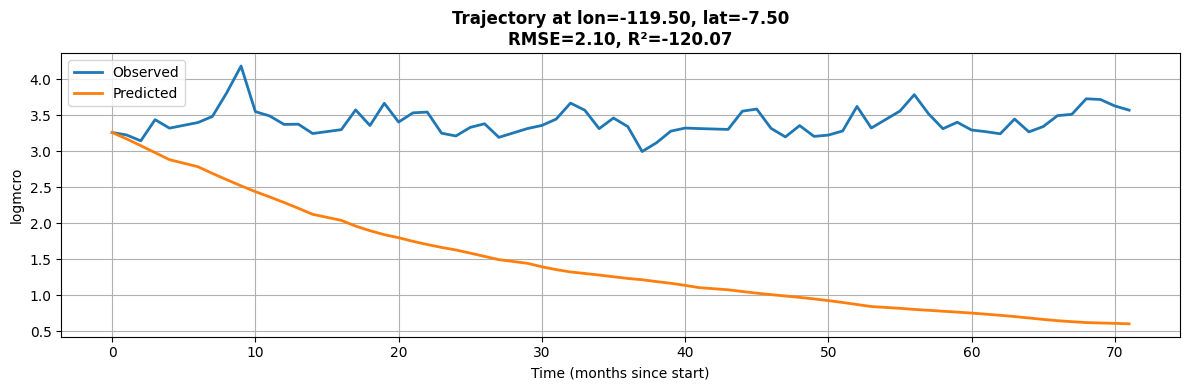

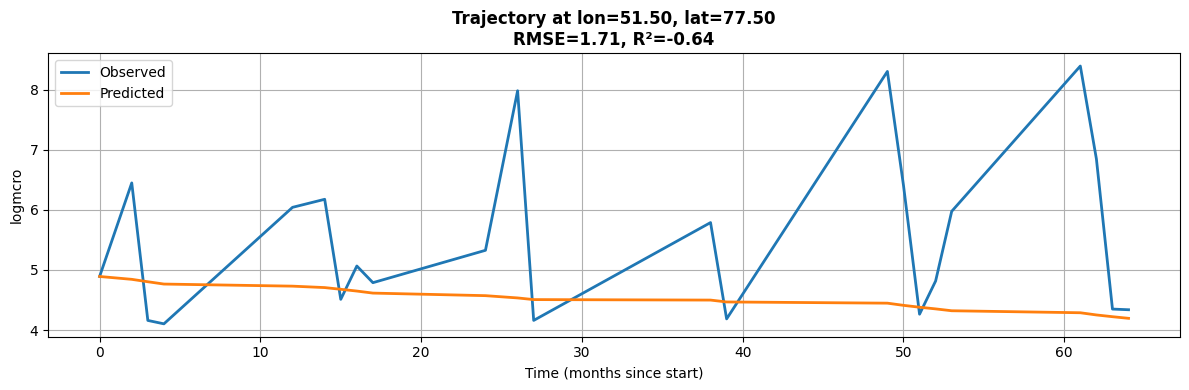

In [54]:
# import random
# # Choose N random locations
# N = 5
# sampled_locs = random.sample(list(results_dict.keys()), N)
# for loc in sampled_locs:
#     df_traj = results_dict[loc]
#     plot_trajectory(loc, df_traj, name='trajs.png', path=chartpath)

In [17]:
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

def plot_multiple_trajectories(results_dict, num_samples=6, save_path=chartpath + "trajs.png", seed=42):
    """
    Plot multiple observed vs predicted trajectories in subplots.
    Automatically adjusts layout based on number of samples.
    """
    random.seed(seed)
    sampled_locs = random.sample(list(results_dict.keys()), min(num_samples, len(results_dict)))

    n = len(sampled_locs)
    ncols = min(3, n)
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows), squeeze=False)
    fig.suptitle("Observed vs Predicted Log Micro Trajectories", fontsize=16, fontweight='bold')

    for i, loc in enumerate(sampled_locs):
        row, col = divmod(i, ncols)
        ax = axes[row][col]
        df_traj = results_dict[loc]

        t = df_traj['time']
        obs = df_traj['obs']
        pred = df_traj['P_pred']

        rmse = np.sqrt(mean_squared_error(obs, pred))
        r2 = r2_score(obs, pred)
        corr, _ = pearsonr(obs, pred)

        ax.plot(t, obs, label='Observed', lw=2)
        ax.plot(t, pred, label='Predicted', lw=2)
        ax.set_title(f"lon={loc[0]:.1f}, lat={loc[1]:.1f}\nRMSE={rmse:.2f}, R²={r2:.2f}, r={corr:.2f}")
        ax.set_xlabel("Time (months)", fontsize=12)
        ax.set_ylabel("logmcro", fontsize=12)
        ax.grid(True)
        ax.legend()

    # Hide unused subplots
    for j in range(i+1, nrows*ncols):
        row, col = divmod(j, ncols)
        fig.delaxes(axes[row][col])
        
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

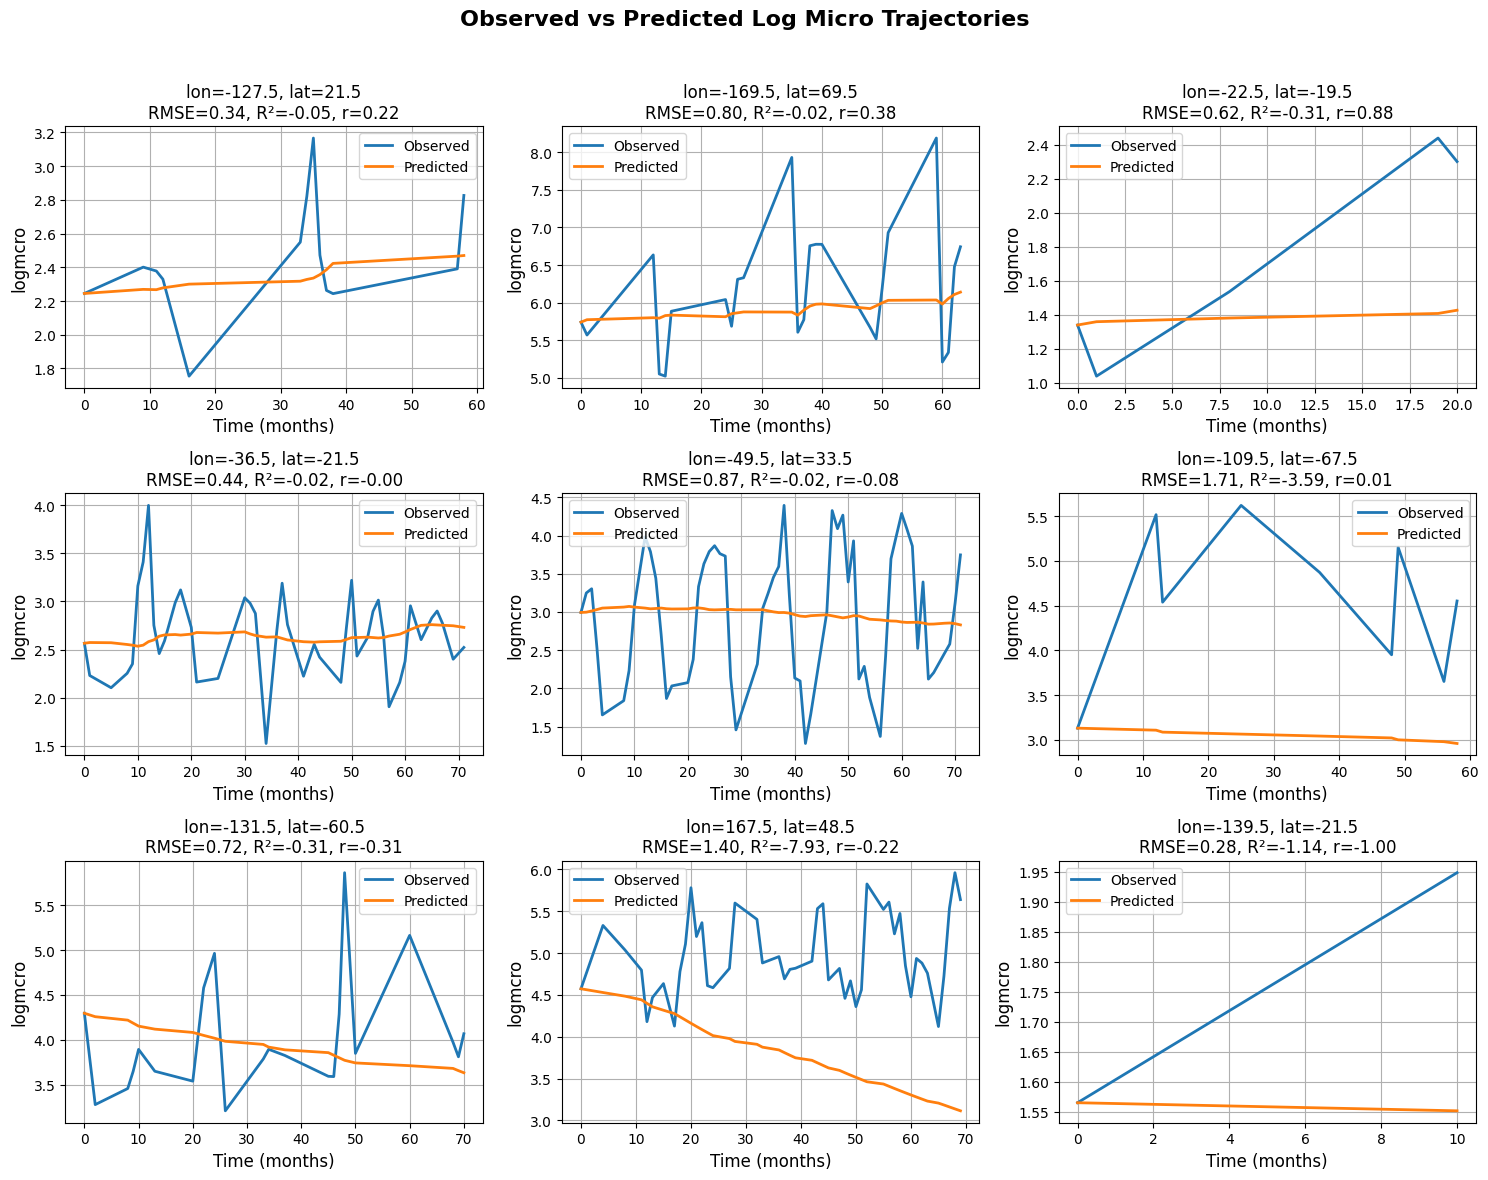

In [18]:
plot_multiple_trajectories(results_dict, num_samples=9)

In [16]:
# Flatten all observed and predicted values
all_obs = []
all_pred = []

for df_traj in results_dict.values():
    obs = df_traj['obs']
    pred = df_traj['P_pred']

    # Filter out NaNs if any
    mask = ~np.isnan(obs) & ~np.isnan(pred)
    all_obs.extend(obs[mask])
    all_pred.extend(pred[mask])

# Convert to arrays
all_obs = np.array(all_obs)
all_pred = np.array(all_pred)

# Compute metrics
overall_rmse = np.sqrt(mean_squared_error(all_obs, all_pred))
overall_r2 = r2_score(all_obs, all_pred)
# Compute Pearson correlation
r, p_value = pearsonr(all_obs, all_pred)

print(f"✅ Overall RMSE: {overall_rmse:.4f}")
print(f"✅ Overall R²:   {overall_r2:.4f}")
print(f"✅ Overall Pearson correlation (r): {r:.4f}")
print(f"📌 p-value: {p_value:.4e}")

✅ Overall RMSE: 1.7117
✅ Overall R²:   -0.8626
✅ Overall Pearson correlation (r): 0.5305
📌 p-value: 0.0000e+00


In [19]:
print(ds['logmcro'].max().values, ds['logmcro'].min().values)

1.8100383 -3.955903
